In [139]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Normalizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import ClusterCentroids
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [140]:
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\DSTI\Python Machine Learning Labs\Project-20221212\books_v2.csv", index_col = "bookID")

# Feature Engineering 

## Data Cleaning 

In [141]:
#Renaming '  num_pages' in order to remove the extra spaces and displaying columns names
df.rename(columns={'  num_pages':'num_pages'}, inplace=True)


In [142]:
#Dropping useless columns: isbn and isbn13
df = df.drop(columns = ['isbn','isbn13'])

In [143]:
#For the language_code column, replacing the value eng-US, en-CA and eng-GB with the value eng
df.language_code = df.language_code.replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'})

In [144]:
df['language_code'] = np.where(df['language_code'] != 'eng', 'other', 'eng')

Keeping top 4 languages & dropping others 

### Date Column

In [145]:
#correcting 2 NaT by correct date
df.loc[31373,"publication_date"]='10/30/2000'
df.loc[45531,"publication_date"] ='6/30/1982'
#df.loc[[31373,45531]]


In [146]:
# Changing the publication_date colummn type to a date format 
df['publication_date'] = pd.to_datetime(df['publication_date'], dayfirst = False, yearfirst = False, errors = 'coerce')


In [147]:
# Splitting date column into month and year columns 
df['month'] = df['publication_date'].dt.month
df['year'] = df['publication_date'].dt.year

<AxesSubplot:xlabel='year', ylabel='average_rating'>

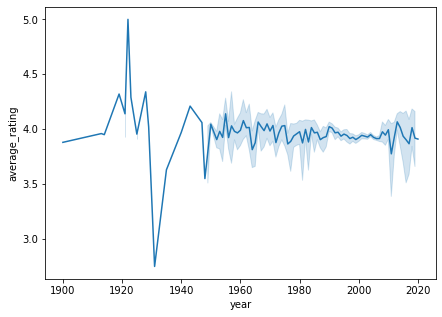

In [148]:
# Average rating over the years
fig = plt.gcf()
fig.set_size_inches(7, 5)
sns.lineplot(x="year", y="average_rating", data=df)

<AxesSubplot:xlabel='month', ylabel='average_rating'>

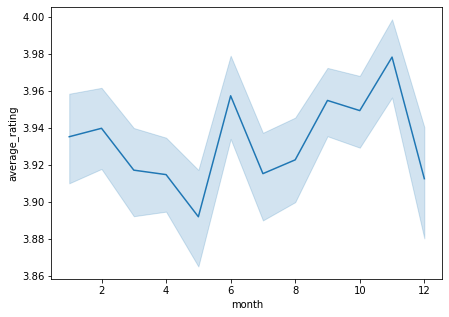

In [149]:
#average rating evolution over the months 
fig = plt.gcf()
fig.set_size_inches(7, 5)
sns.lineplot(x="month", y="average_rating", data=df)
# better rating around end of the year 

In [150]:
years = df.groupby(["year"]).describe().average_rating


## Rating counts = 0 & Avg Rating = 0

In [151]:
# Dropping the rows where the  average rating of a book is set to 0 AND rating counts set to 0
len(df.loc[(df['average_rating'] == 0) & (df['ratings_count'] == 0)])
idx_to_drop = df.loc[(df['average_rating'] == 0) & (df['ratings_count'] == 0)].index
df.drop(idx_to_drop, inplace=True)

## Author Column

In [152]:
# single author vs multiple authors -> new column "Authors_2" = Single/Multiple -> boolean
df['number_of_authors']=np.where(df['authors'].str.split(pat="/").str.len()==1, "single", "multiple")

#keep 1st author in case of multiple authors and analyze correlation
df['primary_author']=df['authors'].str.split(pat="/").str[0]

In [153]:
#author_page=df.groupby('primary_author')['num_pages'].mean()
#frames=[author_page, authors]
#pd.concat(frames,axis=1).sort_values('count', ascending = False)

In [154]:
df.groupby("number_of_authors")[["average_rating", "ratings_count"]].describe()

average_rating                                             \
                           count      mean       std  min   25%   50%   75%   
number_of_authors                                                             
multiple                  4552.0  3.975415  0.293673  2.0  3.81  3.99  4.17   
single                    6549.0  3.920205  0.297133  1.0  3.75  3.94  4.11   

                       ratings_count                                           \
                   max         count          mean            std  min    25%   
number_of_authors                                                               
multiple           5.0        4552.0  13984.349956  101468.177125  0.0   71.0   
single             5.0        6549.0  20754.567568  119670.668244  0.0  164.0   

                                              
                      50%     75%        max  
number_of_authors                             
multiple            401.5  2585.5  2339585.0  
single             1202.0  7265.0  4597666.0

## Handling Outliers

In [155]:
# raw_df = df with ouliers 
raw_df = df.copy()

### Pages column

In [156]:
percentile25 = df['num_pages'].quantile(0.25)
percentile75 = df['num_pages'].quantile(0.75)
iqr = percentile75 - percentile25
print ("IQR: ",iqr)
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
df = df[df['num_pages']< upper_limit]

IQR:  223.0


### Rating_count

In [157]:
percentile25_rating = df['ratings_count'].quantile(0.25)
percentile75_rating = df['ratings_count'].quantile(0.75)
iqr2 = percentile75_rating - percentile25_rating
print ("IQR: ",iqr2)
upper_limit_rating = percentile75_rating + 1.5 * iqr2
lower_limit_rating = percentile25_rating - 1.5 * iqr2
df = df[df['ratings_count']< upper_limit_rating]

IQR:  4868.5


### Text_Reviews_Count

In [158]:
percentile25_text = df['text_reviews_count'].quantile(0.25)
percentile75_text = df['text_reviews_count'].quantile(0.75)
iqr3 = percentile75_text - percentile25_text
print ("IQR: ",iqr3)
upper_limit_text = percentile75_text + 1.5 * iqr3
lower_limit_text = percentile25_text - 1.5 * iqr3
df = df[df['text_reviews_count']< upper_limit_text]

IQR:  101.0


In [159]:
# original_df = 11127
#raw_df = 11101 rows
#df = 7955 rows

## Correlation

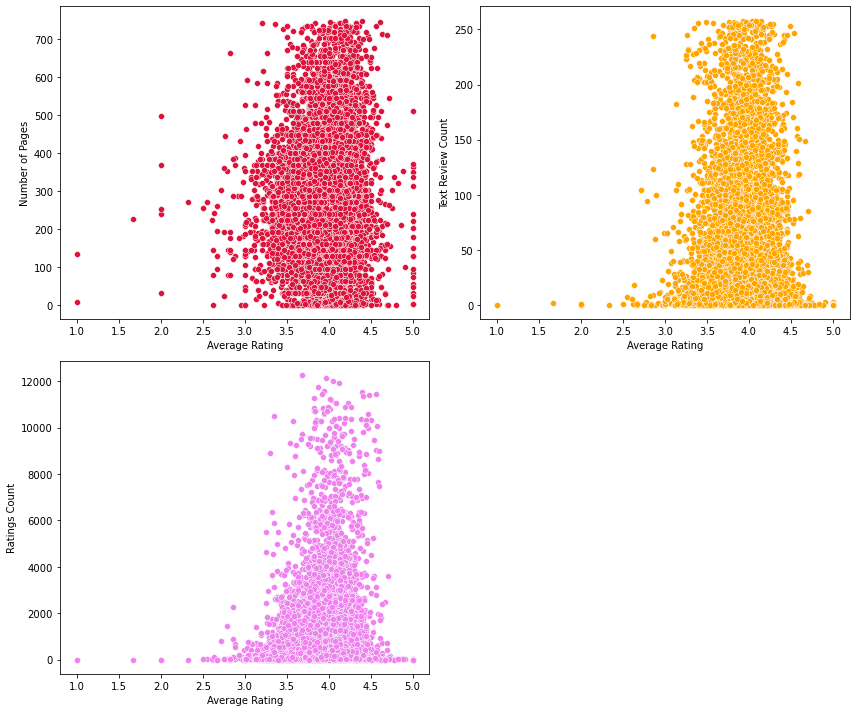

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Average Rating vs Number of Pages
sns.scatterplot(x="average_rating", y="num_pages", data=df, ax=axes[0, 0], color='crimson')
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_ylabel("Number of Pages")

# Average Rating vs Text Review Count
sns.scatterplot(x="average_rating", y="text_reviews_count", data=df, ax=axes[0, 1], color='orange')
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_ylabel("Text Review Count")

# Average Rating vs Ratings Count
sns.scatterplot(x="average_rating", y="ratings_count", data=df, ax=axes[1, 0], color='violet')
axes[1, 0].set_xlabel("Average Rating")
axes[1, 0].set_ylabel("Ratings Count")

# remove empty subplot
fig.delaxes(axes[1, 1])

fig.tight_layout()

# show the plot
#plt.show()


## Categorization avg rating 

In [161]:
# 5.001 to include the rating = 5
bins = [ 0, 2.51, 5.001]
label = ['Low',"High"]
raw_df['cat_rating'] = pd.cut(raw_df['average_rating'], bins, labels=label, right = False)
df['cat_rating'] = pd.cut(df['average_rating'], bins, labels=label, right = False)



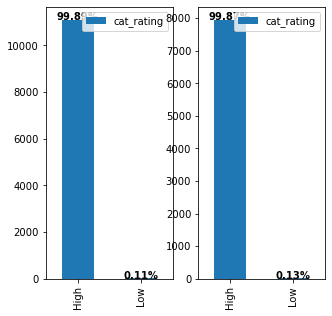

In [162]:
# Chart for average rating by category (raw_df)
plt.subplot(1,2,1)
value_counts = raw_df['cat_rating'].value_counts()
ax1 = value_counts.plot(kind='bar', figsize=(5, 5))
# Add percentage labels to each bar
for i in ax1.patches:
    height = i.get_height()
    ax1.text(i.get_x() + i.get_width() / 2., height + 0.5, f'{height/len(raw_df)*100:.2f}%', ha='center', fontweight='bold')
ax1.legend()

# Chart for average rating by category (df)
plt.subplot(1,2,2)
value_counts2 = df['cat_rating'].value_counts()
ax2 = value_counts2.plot(kind='bar', figsize=(5, 5))
# Add percentage labels to each bar
for i in ax2.patches:
    height = i.get_height()
    ax2.text(i.get_x() + i.get_width() / 2., height + 0.5, f'{height/len(df)*100:.2f}%', ha='center', fontweight='bold')
ax2.legend()

plt.show()


In [163]:
df["cat_rating"] = df['cat_rating'].replace({'High': 2, "Low": 1 })
raw_df["cat_rating"] = raw_df['cat_rating'].replace({'High': 2, "Low": 1 })

In [164]:
avg_count = raw_df.groupby(["cat_rating"]).mean().ratings_count.to_dict()

In [169]:
def count_guesser(count):
    avg = avg_count[count]
    return avg

In [170]:
for i in avg_count.keys():
    temp_df = raw_df.loc[(raw_df.cat_rating == i),:]
    missing_values_index = temp_df.loc[temp_df.ratings_count ==0].index
    raw_df.loc[missing_values_index,"ratings_count"] =count_guesser(i)

## Data Processing 

In [173]:
raw_df["co-author"] = raw_df['number_of_authors'].replace({'single': 0, 'multiple': 1})


In [174]:
labelencoder = LabelEncoder()
raw_df['language_cat'] = labelencoder.fit_transform(raw_df['language_code'])
raw_df['author_cat'] = labelencoder.fit_transform(raw_df['primary_author'])
df['language_cat'] = labelencoder.fit_transform(df['language_code'])
df['author_cat'] = labelencoder.fit_transform(df['primary_author'])


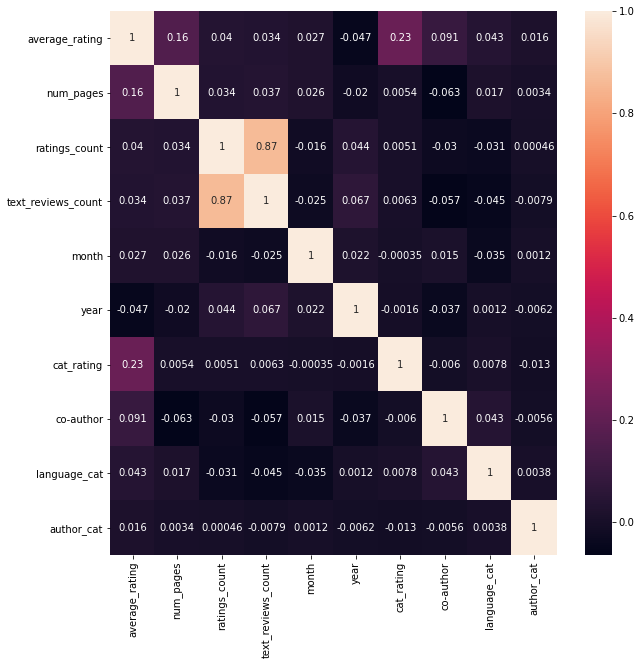

In [175]:
plt.figure(figsize=(10,10))
sns.heatmap(raw_df.corr(),annot=True)
plt.show()

In [177]:
raw_df.columns

Index(['title', 'authors', 'average_rating', 'language_code', 'num_pages',
       'ratings_count', 'text_reviews_count', 'publication_date', 'publisher',
       'month', 'year', 'number_of_authors', 'primary_author', 'cat_rating',
       'co-author', 'language_cat', 'author_cat'],
      dtype='object')

In [176]:
raw_df = raw_df.reset_index(drop=True)


# Modeling

In [202]:
df_train, df_test = train_test_split(raw_df,test_size = 0.2)

In [215]:
X_train = df_train[['author_cat',"language_cat"]]
y_train = df_train[['cat_rating']]

X_test = df_test[['author_cat','language_cat']]
y_test = df_test[['cat_rating']]


Gradient Boosting Classifier
Confusion Matrix:
[[   0    2]
 [ 638 1581]]

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.71      0.83      2219

    accuracy                           0.71      2221
   macro avg       0.50      0.36      0.42      2221
weighted avg       1.00      0.71      0.83      2221


Execution time:  0.17081952095031738 



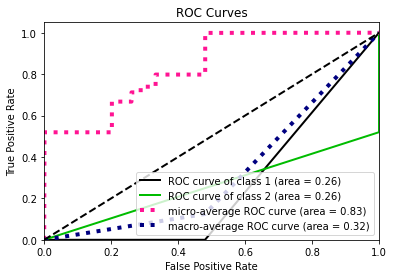

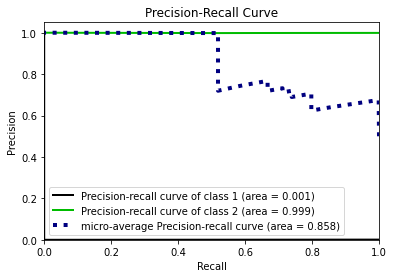

In [237]:
from imblearn.under_sampling import RandomUnderSampler
import time

#undersampling
under = RandomUnderSampler()
X_under, y_under = under.fit_resample(X_train, y_train)
#oversampling
over = SMOTE()
X_bal, y_bal = over.fit_resample(X_under, y_under)
#modeling
model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.01, max_depth=5, random_state=63)
name = "Gradient Boosting Classifier"

start = time.time()
model.fit(X_bal, y_bal)
predictions = model.predict(X_test)
print ('\033[1m'+name+'\033[0m')
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))
print('\nExecution time: ', time.time() - start, '\n')
y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)
plot_roc(y_test, y_score)
plt.show()
plot_precision_recall(y_test, y_score)
plt.show()

In [228]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
param_dist = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

In [218]:
# RandomizedSearchCV is faster than GridSearchCV
estimator = GradientBoostingClassifier(random_state=42)
search = RandomizedSearchCV(estimator=estimator, param_distributions=param_dist, n_iter=20, cv=5)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [5, 50, 250, 500]})

In [219]:
print(search.best_params_)

{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.01}


Gradient Boosting Classifier
Confusion Matrix:
[[   0    2]
 [ 405 1814]]

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.82      0.90      2219

    accuracy                           0.82      2221
   macro avg       0.50      0.41      0.45      2221
weighted avg       1.00      0.82      0.90      2221



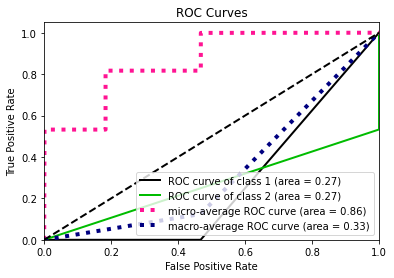

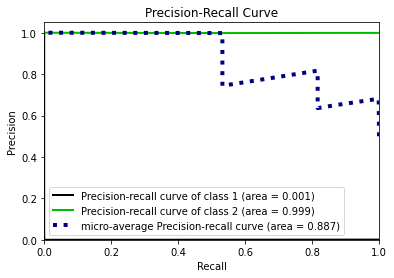


Execution time:  0.667022705078125 



In [267]:
under = RandomUnderSampler()
X_under, y_under = under.fit_resample(X_train, y_train)
#oversampling
over = SMOTE()
X_bal, y_bal = over.fit_resample(X_under, y_under)


#modeling
model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=1, random_state = 63)
name = "Gradient Boosting Classifier"



start = time.time()
model.fit(X_bal, y_bal)
predictions = model.predict(X_test)
    
print ('\033[1m'+name+'\033[0m')

  
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))
y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)
plot_roc(y_test, y_score)
plt.show()
    
plot_precision_recall(y_test, y_score)
plt.show()
    
print('\nExecution time: ', time.time() - start, '\n')

# Next Steps



normalisé des données influence sur models? 
https://datasans.medium.com/exploratory-data-analysis-cheatsheet-everything-you-might-need-36230538484d
data preprocessing 
oui avec randomn forest 
non avec nouveau model 

interpretation des scores? comprendre? 

random forest best suited so far 
still after normalisation? 

ameliorer: 
jouer sur nombre de feautures (X(min:3); pages, language, author-cat ) 
sur hyper-parameters du model (n-estimators...)